# Table of Contents
 <p>

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import h5py

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [2]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
# Newton gravity constant
# lal.G_SI: 6.67384e-11
G_Newt = 6.67384e-11

In [4]:
# light speed
# lal.C_SI: 299792458.0
c_ls = 299792458.0

In [5]:
# lal.MSUN_SI: 1.9885469549614615e+30
MSUN_SI = 1.9885469549614615e+30

In [6]:
MTSUN_SI = 4.925491025543576e-06

In [7]:
# lal.GAMMA: 0.5772156649015329
GAMMA = 0.5772156649015329

In [8]:
def Msun_to_sec(M):
    """
    convert mass (in units of solar masses)
    into seconds
    """
#     return M *lal.MSUN_SI* G_Newt / c_ls**3.
    return M * MTSUN_SI

In [9]:

def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (MTSUN_SI*Mtot)

In [10]:

def HztoMf(Hz, M):
    """HztoMf(Hz, M)
    """
    return Hz * (MTSUN_SI*M)


In [11]:

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (MTSUN_SI*Mtot)

In [12]:
def MftoHz(Mf, M):
    """MftoHz(Mf, M)
    """
    return Mf / (MTSUN_SI*M)

In [13]:
nrfiles = [
    '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5', #q=1
    '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5', #q=2
    '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5', #q=4
    '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5', #5
    '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5' #10
]

# get data
# nrfiles = dict(
#     q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
#     q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
#     q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
#     q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
#     q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5'
# )

In [246]:
with h5py.File(nrfiles[0], 'r') as f: # open file
    tmp_x = f['phase_l2_m-2']['X'][:]
    tmp_y = f['phase_l2_m-2']['Y'][:]
    
    x = np.linspace(tmp_x[0], tmp_x[-1], 3000)
    iy = IUS(tmp_x, tmp_y)
    y = iy(x)
    yprime = iy.derivative()(x) / 2. / np.pi


(-200, 100)

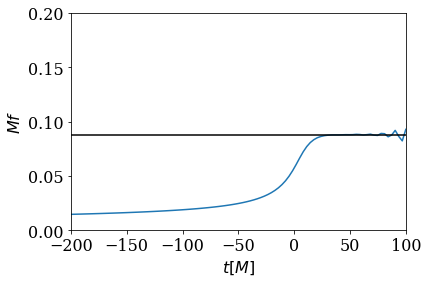

In [247]:
plt.figure()
plt.plot(x, yprime)
plt.ylabel(r"$Mf$")
plt.xlabel(r"$t [M]$")
plt.ylim(0,0.2)
plt.axhline(0.088, c='k')
plt.xlim(-200, 100)

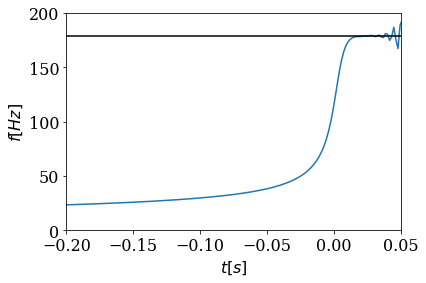

In [248]:
plt.figure()
plt.plot(MtoS(x, 100), MftoHz(yprime, 100))
plt.ylabel(r"$f [Hz]$")
plt.xlabel(r"$t [s]$")
plt.ylim(0,200)
plt.xlim(-0.2,0.05)
plt.axhline(MftoHz(0.088,100), c='k')

In [249]:
def TaylorT3_Omega_new(t, tc, eta, M):
    """
    Orbital frequency
    equation 7 in 0901.2437
    
    3.5PN term from https://arxiv.org/pdf/gr-qc/0610122.pdf and https://arxiv.org/pdf/0907.0700.pdf
    and this too apparently https://arxiv.org/pdf/gr-qc/0406012.pdf?
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralTaylorT3.c
    
    https://git.ligo.org/lscsoft/lalsuite/blob/master/lalsimulation/src/LALSimInspiralPNCoefficients.c
    
    t: time
    tc: coalescence time
    eta: symmetric mass ratio
    M: total mass (Msun)
    """
    
    Msec = Msun_to_sec(M)
    Msec = M
    
    pi2 = np.pi*np.pi
    
    c1 = eta/(5.*Msec);
    td = c1 * (tc - t)
    
    theta = td**(-1./8.) # -1./8. = -0.125 
    
    theta2 = theta*theta
    theta3 = theta2*theta
    theta4 = theta3*theta
    theta5 = theta4*theta
    theta6 = theta5*theta
    theta7 = theta6*theta

    # pre factor
    ftaN = 1. / ( 8. * np.pi * Msec  )
    # 0PN
    fts1 = 1.
    # 0.5PN = 0 in GR
    # 1PN
    fta2 = 7.43/26.88 + 1.1/3.2 * eta
    # 1.5PN
    fta3 = -3./10. * np.pi
    # 2PN
    fta4 = 1.855099/14.450688 + 5.6975/25.8048 * eta + 3.71/20.48 * eta*eta
    # 2.5PN
    fta5 = (-7.729/21.504 + 1.3/25.6 * eta) * np.pi
    # 3PN
    fta6 = -7.20817631400877/2.88412611379200 + 5.3/20.0 * pi2 + 1.07/2.80 * GAMMA  \
           + (25.302017977/4.161798144 - 4.51/20.48 * pi2) * eta \
           - 3.0913/183.5008 * eta*eta + 2.35925/17.69472 * eta*eta*eta
            
    # 3.5PN
    fta7 = (-1.88516689/4.33520640 - 9.7765/25.8048 * eta + 1.41769/12.90240 * eta*eta) * np.pi

    # 3PN log term
    ftal6 = 1.07/2.80
    

    full = theta3*ftaN * (1. \
             + fta2*theta2 \
             + fta3*theta3 \
             + fta4*theta4 \
             + fta5*theta5 \
             + (fta6 + ftal6*np.log(2.*theta))*theta6 \
             + fta7*theta7)
    
    return full

In [250]:
def TaylorT3_Omega(t, tc, nu, M):
    """
    Orbital frequency
    equation 7 in 0901.2437
    
    3.5PN term from https://arxiv.org/pdf/gr-qc/0610122.pdf and https://arxiv.org/pdf/0907.0700.pdf
    and this too apparently https://arxiv.org/pdf/gr-qc/0406012.pdf?
    
    t: time
    tc: coalescence time
    nu: symmetric mass ratio
    M: total mass (Msun)
    """
    
#     tau = nu * (tc - t) / (5 * M*MTSUN_SI)
    tau = nu * (tc - t) / (5 * M)
    
    theta = tau**(-1./8)
    pre = 1./8. * theta**(3) / np.pi
    
    gamma = 0.5772 #??
    
    PN0 = 1.
    PN1 = (743./2688. + 11./32.*nu)
    PN1p5 = -3./10. * np.pi
    PN2 = (1855099./14450688. + 56975./258048.*nu + 371./2048. * nu**2.)
    PN2p5 = (-7729./21504. + 13./256.*nu) * np.pi
    PN3 = -720817631400877./288412611379200. + 53./200.*np.pi**2. + 107./280.*gamma \
        + (25302017977./4161798144. - 451./2048. * np.pi**2)*nu \
        - 30913./1835008. * nu**2. + 235925./1769472.*nu**3.

    # 3PN log term
    PN3log = -107./2240. * np.log(tau/256.)
        
    PN3p5 = ((-188516689./433520640) - ((97765./258048) * nu) + ((141769./1290240) * nu**2.)) * np.pi

    
    full = pre * ( PN0 \
                  + PN1*tau**(-1./4.) \
                  + PN1p5*tau**(-3./8.) \
                  + PN2*tau**(-1./2.) \
                  + PN2p5*tau**(-5./8.) \
                  + ( PN3 + PN3log )*tau**(-3./4.) \
                  + PN3p5*tau**(-7./8.) \
                 )

    return full

In [251]:
1.07/2.80 * np.log(2.)

0.26488124399969337

In [252]:
-107./2240. * np.log(1./256.)

0.26488124399969337

In [253]:
import pycbc

In [254]:
from pycbc import waveform

In [255]:
hp,hc = waveform.get_td_waveform(approximant="TaylorT3", mass1=50, mass2=50, f_lower=2, delta_t=1./4096./2, phase_order=7)
t3freq = waveform.utils.frequency_from_polarizations(hp,hc)


hp2,hc2 = waveform.get_td_waveform(approximant="TaylorT3", mass1=25, mass2=25, f_lower=10, delta_t=1./4096./2/2, phase_order=7)
t3freq2 = waveform.utils.frequency_from_polarizations(hp2,hc2)

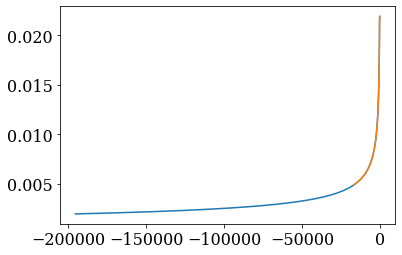

In [256]:
plt.figure()
plt.plot(StoM(t3freq.sample_times,100)/2, HztoMf(t3freq,100)*2)
plt.plot(StoM(t3freq2.sample_times,100), HztoMf(t3freq2,100))

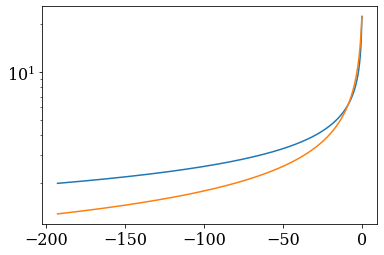

In [257]:
plt.figure()
plt.plot(t3freq.sample_times, t3freq)

mmm=100
# times_in_m = MtoS(t3freq.sample_times,mmm)
times_in_s = t3freq.sample_times
tc=1
t3_theta = (0.25 * (tc - times_in_s) / (5. * mmm) )**(-1./8.)
t3_theta_1 = t3_theta**(3.)

leading_order_t3 = (t3_theta_1 / (8*np.pi*mmm)) * (1. + ((3715./8064) + (55./96.)*0.25)*t3_theta**2. )

plt.plot(t3freq.sample_times, MftoHz(leading_order_t3,mmm)/np.pi)
plt.yscale('log')


In [258]:
times = np.linspace(-8000, -100, 300)

In [259]:
Msun_to_sec(1)

4.925491025543576e-06

In [260]:
om = TaylorT3_Omega(MtoS(times,1), 0.00001, 0.25, 1)
# om = TaylorT3_Omega(times, 0., 0.25, 100)

In [261]:
# om = TaylorT3_Omega_new(times, 0., 0.25, 100)
# om = TaylorT3_Omega_new(MtoS(times,1), 0., 0.25, 1)

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


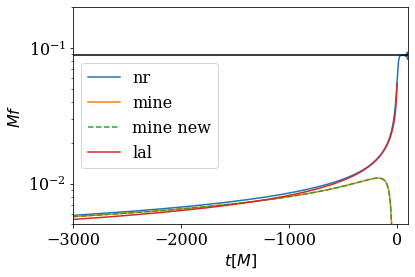

In [262]:
plt.figure()
plt.plot(x, yprime, label='nr')

om = TaylorT3_Omega(x[x<0], 0.001, 0.25, 1)
plt.plot(x[x<0], om, label='mine')
om = TaylorT3_Omega_new(x[x<0], 0.001, 0.25, 1)
plt.plot(x[x<0], om, ls='--', label='mine new')
# plt.plot(x[x<0], HztoMf(om,1))

plt.plot(StoM(t3freq.sample_times,100)/100, HztoMf(t3freq,100)*100/10/2, label='lal')

plt.ylabel(r"$M f$")
plt.xlabel(r"$t [M]$")
plt.ylim(5e-3,0.2)
plt.axhline(0.088, c='k')
plt.xlim(-3000, 100)

plt.yscale('log')
plt.legend()

In [263]:
# plt.figure(figsize=(20,10))
# plt.plot(StoM(t3freq.sample_times,100), t3freq, label='lal')
# plt.plot(times, MftoHz(om,100)/np.pi, label='me')
# # plt.plot(x, yprime/2/np.pi, label='nr')
# # plt.ylim(1e-3,0.6)
# # plt.xlim(-2000, 50)
# plt.yscale('log')
# plt.legend()

In [264]:
from scipy.optimize import curve_fit

In [265]:
# fit straight up PN to NR

In [266]:
# THIS IS A GOOD ONE
def func(t,tc):
    nu=0.25
    M=1
    return TaylorT3_Omega( MtoS(t,1) , tc, nu, M)/np.pi

In [267]:
mask = (x > -8000) & (x < 100)

In [268]:
popt, pcov = curve_fit(func, x[mask], yprime[mask], maxfev=10000, p0=(0.002))

In [269]:
popt

array([176.33987969])

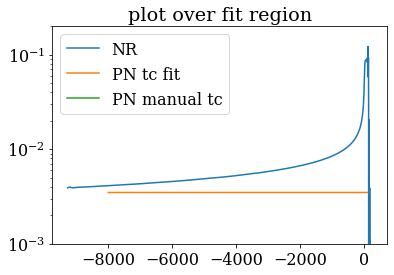

In [270]:
plt.figure()
plt.plot(x, yprime, label='NR')
# plt.plot(x, func(x, *popt), label='PN tc fit all ')
plt.plot(x[mask], func(x[mask], *popt), label='PN tc fit')
plt.plot(x[mask], func(x[mask], 0.000001), label='PN manual tc')

# plt.plot(times, func(times, *popt))
plt.ylim(1e-3,0.2)
# plt.xlim(-2000, 50)
# plt.xlim(-2000, 50)
plt.legend()
plt.title("plot over fit region")
plt.yscale('log')

In [271]:
def rational(x, p, q):
    """
    The general rational function description.
    p is a list with the polynomial coefficients in the numerator
    q is a list with the polynomial coefficients (except the first one)
    in the denominator
    The zeroth order coefficient of the denominator polynomial is fixed at 1.
    Numpy stores coefficients in [x**2 + x + 1] order, so the fixed
    zeroth order denominator coefficent must comes last. (Edited.)
    """
    return np.polyval(p, x) / np.polyval(q + [1.0], x)

def rational3_3(x, p0, p1, p2, q1, q2):
    return rational(x, [p0, p1, p2], [q1, q2])

In [272]:
# def func(t, a, b,c,d,e,f):
#     nu=0.25
#     M=100
#     tc=0
#     tau = nu * (tc - t) / (5 * M)
#     return a * (TaylorT3_Omega(t, tc, nu, M) + b*tau**(-7./8.) + c*tau**(-8./8.)+ d*tau**(-9./8.)+ e*tau**(-10./8.)+ f*tau**(-11./8.)) / np.pi

In [273]:
# def func(t, b,c,d,e,f):
#     nu=0.25
#     M=100
#     tc=0
#     tau = nu * (tc - t) / (5 * M)
#     return (TaylorT3_Omega(t, tc, nu, M) + b*tau**(-7./8.) + c*tau**(-8./8.) + d*tau**(-9./8.)+ e*tau**(-10./8.)+ f*tau**(-11./8.)) / np.pi

In [274]:
# THIS IS A GOOD ONE
def func(t, b,c,tc):
    nu=0.25
    M=1
#     tc=0
    tau = nu * (tc - t) / (5 * M)
    return (TaylorT3_Omega(t, tc, nu, M) + b*tau**(-7./8.) + c*tau**(-9./8.)) / np.pi

In [275]:
# def func(t, b,tc):
#     nu=0.25
#     M=100
# #     tc=0
#     tau = nu * (tc - t) / (5 * M)
#     return (TaylorT3_Omega(t, tc, nu, M) + b*tau**(-9./8.)) / np.pi

In [276]:
# def func(t, b, c,d,e):
#     nu=0.25
#     M=100
#     tc=0
#     tau = nu * (tc - t) / (5 * M)
#     return (TaylorT3_Omega(t, tc, nu, M) + b*tau**(-7./8.)+ c*tau**(-8./8.) + d*tau**(-9./8.) + e*tau**(-10./8.)) / np.pi

In [277]:
def func_rational(t, a, p0, p1, p2, q1, q2):
    nu=0.25
    M=1
    tc=0
    tau = nu * (tc - t) / (5 * M)
    return a * (TaylorT3_Omega(t, tc, nu, M) + rational3_3(tau**(1./8.), p0, p1, p2, q1, q2))

In [278]:
mask = (x > -1000) & (x < -100)

In [279]:
popt, pcov = curve_fit(func, x[mask], yprime[mask], maxfev=10000)
# popt_rat, pcov_rat = curve_fit(func_rational, x[mask], yprime[mask], maxfev=10000, p0=(1.,0.2, 0.3, 0.5, -1.0, 2.0))

In [280]:
popt

array([  1.00879296,  -1.03285834, 212.24878163])

In [281]:
# popt_rat

Text(0.5, 1.0, 'plot over fit region')

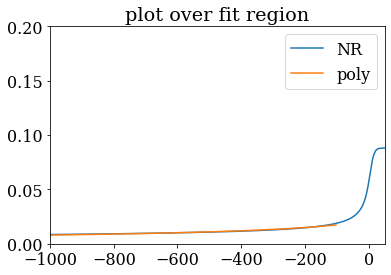

In [282]:
plt.figure()
plt.plot(x, yprime, label='NR')
plt.plot(x[mask], func(x[mask], *popt), label='poly')
# plt.plot(x[mask], func_rational(x[mask], *popt_rat), label='rational function', ls='--')
# plt.plot(times, func(times, *popt))
plt.ylim(0,0.2)
plt.xlim(-1000, 50)
plt.legend()
plt.title("plot over fit region")

Text(0.5, 1.0, 'plot over wider times (Extrapolating)')

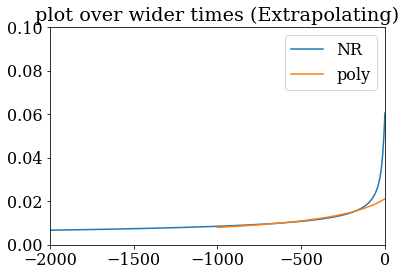

In [283]:
extrap_times = np.linspace(-1000, -1, 1000)

plt.figure()
plt.plot(x, yprime, label='NR')
plt.plot(extrap_times, func(extrap_times, *popt), label='poly')
# plt.plot(extrap_times, func_rational(extrap_times, *popt_rat), label='rational function', ls='--')
# plt.plot(times, func(times, *popt))
plt.ylim(0,0.1)
plt.xlim(-2000, 0)
plt.legend()
plt.title("plot over wider times (Extrapolating)")

Text(0.5, 1.0, 'residuals')

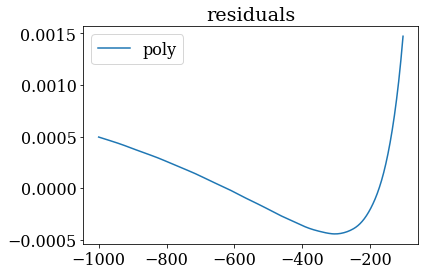

In [284]:
plt.figure()
plt.plot(x[mask], yprime[mask] - func(x[mask], *popt), label='poly')
# plt.plot(x[mask], yprime[mask] - func_rational(x[mask], *popt_rat), label='rational function')
# plt.plot(times, func(times, *popt))
# plt.ylim(0,0.6)
# plt.xlim(-1000, 50)
plt.legend()
plt.title("residuals")

## lmfit

In [285]:
import lmfit
from lmfit import Minimizer, Parameters, report_fit

In [286]:
import phenom

In [287]:
phenom.eta_from_q(10)

0.08264462809917356

In [288]:
class Model(object):
    def __init__(self, times_nr, freq_nr):
        """
        time and freq array to fit
        """
        self.times_nr = times_nr
        self.freq_nr = freq_nr
        
    def model_freq_mr(self, params, t):
        
        tc = params['tc']
        b = params['b']
        c = params['c']
        d = params['d']
        nu = 0.25
        M = 1
        
        tau = nu * (tc - t) / (5*M)
#         tau = np.sqrt((nu * (tc - t) / (5*M))**2 + 1)
        
#         model = (TaylorT3_Omega(t, tc, nu, M) + b*tau**(-7./8.) + c*tau**(-9./8.) + d*tau**(-10./8.))
        model = (TaylorT3_Omega_new(t, tc, nu, M) + b*tau**(-7./8.) + c*tau**(-9./8.) + d*tau**(-10./8.))
        
        return model

    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-200, t2=0):

        self.model_freq_mr_mask = (self.times_nr > t1) & (self.times_nr < t2)
        self.fit_times = self.times_nr[self.model_freq_mr_mask]
        self.fit_data = self.freq_nr[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('tc', value=20., min=-500, max=400)
        
        params.add('b', value=0, min=-300, max=300, vary=True)
        params.add('c', value=0., min=-2000, max=2000, vary=True)
        params.add('d', value=0., min=-2000, max=2000, vary=True)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 116
    # variables        = 4
    chi-square         = 1.8318e-10
    reduced chi-square = 1.6355e-12
    Akaike info crit   = -3144.20240
    Bayesian info crit = -3133.18804
[[Variables]]
    tc:  16.1195559 +/- 0.08956039 (0.56%) (init = 20)
    b:  -0.00470092 +/- 1.7931e-04 (3.81%) (init = 0)
    c:   0.02187254 +/- 0.00102646 (4.69%) (init = 0)
    d:   0.05801232 +/- 9.8932e-04 (1.71%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, d)  = -1.000
    C(b, c)  = -0.999
    C(b, d)  =  0.997
    C(tc, d) =  0.984
    C(tc, c) = -0.978
    C(tc, b) =  0.967


Text(0.5, 1.0, '% error frequency')

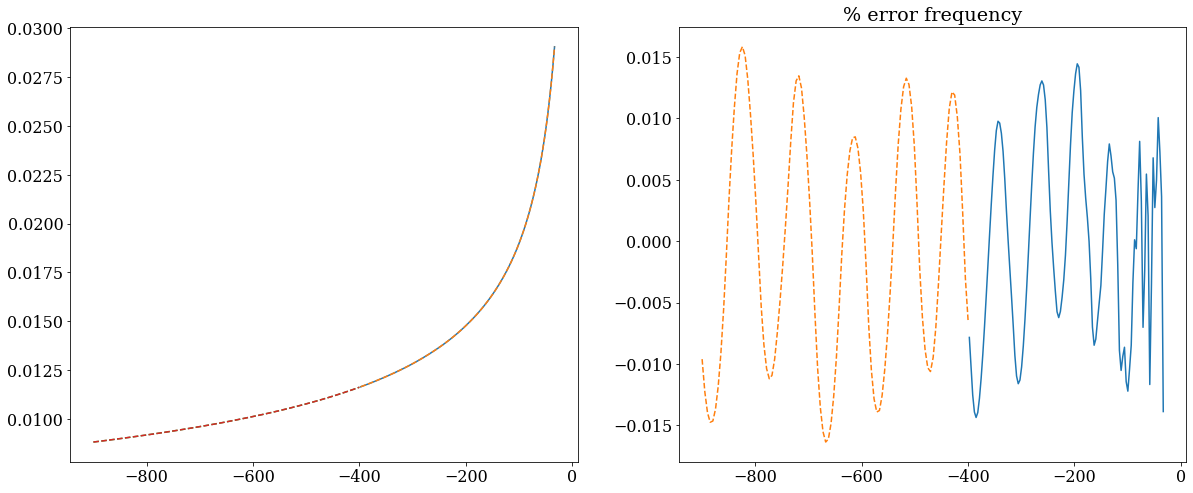

In [289]:
q1_fit = Model(x, yprime)


# the current standard
q1_fit.fit_freq_mr(t1=-400, t2=-30)

# q1_fit.fit_freq_mr(t1=-800, t2=-80)
# q1_fit.fit_freq_mr(t1=-900, t2=-800)
# q1_fit.fit_freq_mr(t1=-400, t2=-80)

# q1_fit.fit_freq_mr(t1=-400, t2=-200)


fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(q1_fit.fit_times, q1_fit.fit_data)
axes[0].plot(q1_fit.fit_times, q1_fit.freq_mr_final, ls='--')


axes[1].plot(q1_fit.fit_times, 100*(q1_fit.fit_data - q1_fit.freq_mr_final)/q1_fit.fit_data)




# extrapolate
xs = np.linspace(-900,-400,100)
# xs = np.linspace(-2000,-400,1000)
ys = q1_fit.model_freq_mr(q1_fit.freq_mr_result.params, xs)

iy_nr = IUS(x, yprime)
y_nr = iy_nr(xs)


axes[0].plot(xs,ys, ls='--')
axes[0].plot(xs,y_nr, ls='--')

axes[1].plot(xs,100*(y_nr-ys)/y_nr, ls='--')

# axes[0].set_yscale('log')

axes[1].set_title('% error frequency')



In [290]:
hp2,hc2 = waveform.get_td_waveform(approximant="SEOBNRv4", mass1=10, mass2=10, f_lower=20, delta_t=1./4096./2/2, phase_order=7)
t3freq2 = waveform.utils.frequency_from_polarizations(hp2,hc2)

In [291]:
eob_t = StoM(t3freq2.sample_times,20)
eob_f = HztoMf(t3freq2, 20)

i_eob_f = IUS(eob_t+4, eob_f)
eob_f_new = i_eob_f(x)

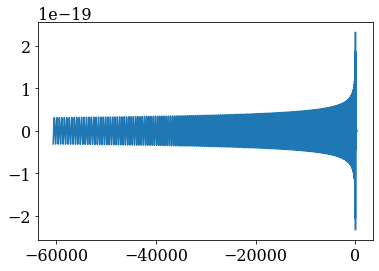

In [292]:
plt.figure()
plt.plot(StoM(hp2.sample_times,20), hp2)

(0.002, 0.1)

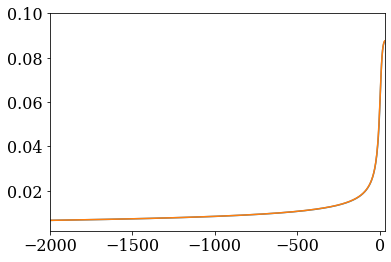

In [293]:
plt.figure()
# plt.plot(eob_t, eob_f )
plt.plot(x, eob_f_new )
plt.plot(x, yprime)
plt.xlim(-2000,30)
plt.ylim(0.002,0.1)

(0.02, 2)

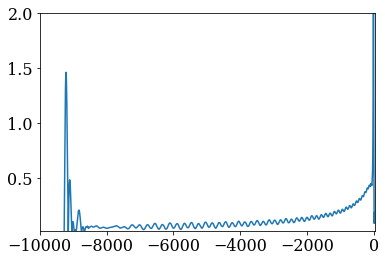

In [294]:
plt.figure()
# plt.plot(eob_t, eob_f )
plt.plot(x, 100*np.abs(eob_f_new - yprime)/eob_f_new )
plt.xlim(-10000,30)
plt.ylim(0.02,2)
# plt.yscale('log')

In [295]:
# xs = np.linspace(-900,-400,100)
xs = np.linspace(-40000,-400,100000)
ys = q1_fit.model_freq_mr(q1_fit.freq_mr_result.params, xs)

i_eob_f = IUS(eob_t+100, eob_f)
eob_f_new = i_eob_f(xs)

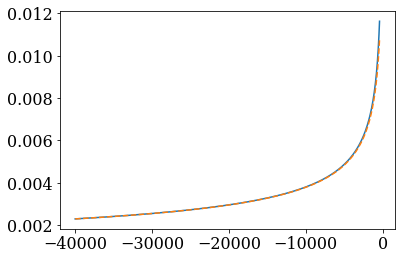

In [296]:
plt.figure()
plt.plot(xs, ys)
plt.plot(xs, eob_f_new, ls='--')

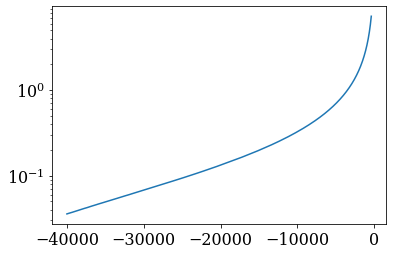

In [297]:
plt.figure()
plt.plot(xs, (100*(ys - eob_f_new)/ys))
# plt.plot(xs, (ys - eob_f_new))
plt.yscale('log')